<a href="https://colab.research.google.com/github/ez7930/JerseySwapPrototpye/blob/main/JerseySwap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



This is a prototpye of a program that is meant to swap the jerseys of nba athletes with Detroit Pistons jerseys. Although it can only swap to front-facing Pistons jerseys for now, you can easily make it work for other team's jerseys by adding different angles of cutouts of their jerseys to the dataset.

Inputs:
1. Picture of an basketball player
2. a box fitted around their jersey

Outputs:

The same picture except the player is wearing a pistons jersey


**Working examples from the program:**
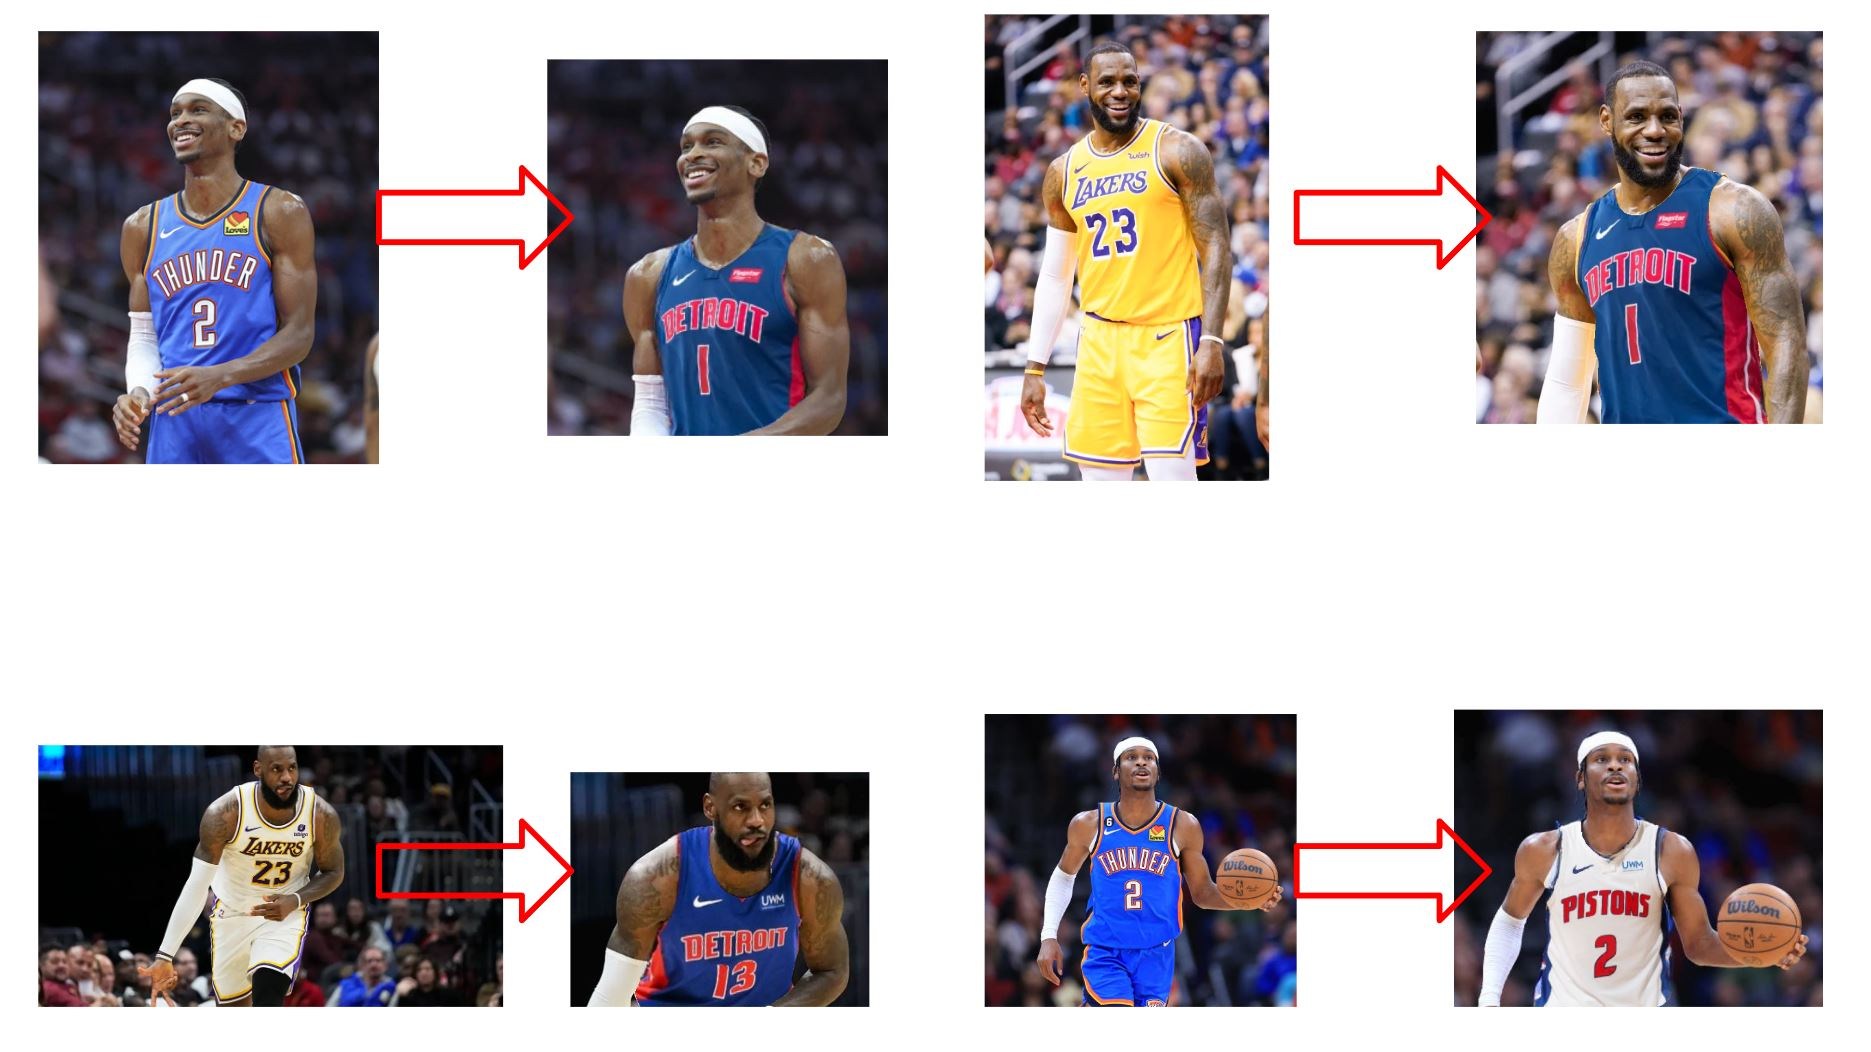

**How it works:**
First, the program takes in an image file and asks the user to draw a bounding box around the jersey using a widget tool. The program uses the Segment Anything Model from Meta to mask and cutout the jersey outlined in the box, then applies a keypoint finding algorithm to find the left, right, and bottom of the collar. The program then uses these keypoints to morph four different prepared cutouts of Pistons jerseys and finds which one fits the best. The selected jersey is then morphed and added under the original image. The program then uses LaMa inpainting to fill in any uncovered space, producing the final result

# Setting Everything Up

**After running the cell below, add your photo to the "input" directory**

---
Note: Takes around 5-15 minutes to run program start to finish with T4 GPU


In [ ]:
!mkdir -p input
!mkdir -p jersey_views

In [ ]:
!wget -q -O /content/jersey_views/front_view.png https://images2.imgbox.com/a6/31/jn1nHrgK_o.png
!wget -q -O /content/jersey_views/right_view.png https://images2.imgbox.com/08/6b/yL4seCa2_o.png
!wget -q -O /content/jersey_views/left_view.png https://images2.imgbox.com/3c/28/fMRvFx3k_o.png
!wget -q -O /content/jersey_views/leaned_view.png https://images2.imgbox.com/ec/dc/M4HF4Azn_o.png

In [ ]:
import os
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

HOME = os.getcwd()
print("HOME:", HOME)

!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

!mkdir -p {HOME}/data

!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-python-headless==4.8.0.74 --quiet
!pip install --upgrade opencv-python

import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import base64
from google.colab import output
from jupyter_bbox_widget import BBoxWidget

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_predictor = SamPredictor(sam)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.0 MB/s eta 0:00:00
HOME: /content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 10.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existi

**When Google Colab asks you to restart the session while running cell below, just click "Cancel"**

---



In [ ]:
#@title Run this sell to set everything up
print('\n> Cloning the repo')
!git clone https://github.com/ez7930/lama.git

print('\n> Install dependencies')
!pip install torch torchvision torchaudio torchtext
!pip install wldhx.yadisk-direct
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival
!pip uninstall kornia -y
!pip install kornia --no-dependencies
!pip install kornia-rs
!pip install pytorch-lightning
!pip install hydra-core
!pip install webdataset
!pip install -r lama/requirements.txt --quiet
!pip install wget --quiet


print('\n> Changing the dir to:')
%cd /content/lama
!mkdir -p data_for_prediction

print('\n> Download the model')
!curl -LJO https://huggingface.co/smartywu/big-lama/resolve/main/big-lama.zip
!unzip big-lama.zip

# print('>fixing opencv')

print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil

canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

# Jersey Swap Code

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 255/255, 255/255, 1])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

#gets the box FOR A CONTOUR
def get_box(cnt):
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.float32(box)
    return box

def reorder_box(box):
  box = box.tolist()

  topleft = min(box, key=lambda p: sum(p))
  box.remove(topleft)
  topright = min(box, key=lambda p: math.sqrt( (topleft[0]-p[0])**2 + (topleft[1]-p[1])**2 ) )
  box.remove(topright)
  bottomright = min(box, key=lambda p: math.sqrt( (topright[0]-p[0])**2 + (topright[1]-p[1])**2 ) )
  box.remove(bottomright)
  bottomleft = box[0]

  final = np.array([topleft, topright, bottomright, bottomleft])
  final = np.float32(final)
  return final

#expands a mask, kernel_size must be at least two and increasing it will increase how much it expands
def expand_mask_edges(mask, kernel_size, iter):

  kernel = np.ones((kernel_size, kernel_size), np.uint8)

  expanded_mask = cv2.dilate(mask, kernel, iterations=iter)

  return expanded_mask



In [ ]:
#gets 5 keypoints for a mask as input, 3 in the collar region and the 2 corners
def get_keypoints(input):
  #finds the contours of the mask
  countours, _ = cv2.findContours(input, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnt = max(countours, key = cv2.contourArea)

  box = get_box(cnt)
  box = reorder_box(box)

  #cuts the mask in half vertically
  threshold = int((box[0][1] + box[3][1])/2)

  #finds the midpoint of the box of the mask
  target = int((box[0][0] + box[1][0])/2)

  #next line gets rid of the weird outerbrackets that are there for some reason fyi
  cnt = cnt[:, 0]
  mask = cnt[:,1] < threshold
  cnt = cnt[mask]

  differences = np.abs(cnt[:,0] - target)

  #finds the index of the "start point", will be somewhere in the collar
  start_index = np.argmin(differences)

  #the start element
  start_element = cnt[start_index]

  # searches left(side1) and right(side2) side for closest value within 5 of the minimum
  #finds the left side of the collar
  side1 = cnt[cnt[:,0] < target]
  side1_min = np.min(side1[:,1])
  side1_mins = side1[side1[:,1] < side1_min+3]
  side1_closest_min = side1_mins[np.argmax(side1_mins[:,0])]

  #finding index of the leftside collar point in the OG contour array
  mask = np.all(cnt == side1_closest_min, axis=1)  # Check all elements in each row
  side1_closest_min_idx = np.nonzero(mask)[0][0]

  side2 = cnt[cnt[:,0] > target]
  side2_min = np.min(side2[:,1])
  side2_mins = side2[side2[:,1] < side2_min+3]
  side2_closest_min = side2_mins[np.argmin(side2_mins[:,0])]

  #finding index of the rightside collar point in the OG contour array
  mask = np.all(cnt == side2_closest_min, axis=1)  # Check all elements in each row
  side2_closest_min_idx = np.nonzero(mask)[0][0]

  #gets the values within the collar
  collar = cnt[side2_closest_min_idx:side1_closest_min_idx]
  collar_max = collar[np.argmax(collar[:, 1])]

  #Now we are finding the corners from here on.
  #creates a coordinate grid for the mask(input), then multiplies the mask by the grid so that only points within the mask exist
  X, Y = np.meshgrid(np.arange(input.shape[1]), np.arange(input.shape[0]))
  coordinate_sums = X + Y
  coordinate_sums = coordinate_sums * input

  #finds the greatest value coordinates - (rows, cols)
  greatest_sum_index = np.argmax(coordinate_sums)
  greatest_value = coordinate_sums.flat[greatest_sum_index]
  cols, rows = np.where(coordinate_sums == greatest_value)

  #rows and cols are numpy arrays for sum reason so gotta undo that witta rows[0] and such
  bot_right_kp = np.array([rows[0], cols[0]])

  #bot_left_kp now, done by flipping the mask finding the bottom right then flipping it back basically(minor issue with it?)
  coordinate_sums = X + Y
  coordinate_sums = coordinate_sums * np.fliplr(input)
  coordinate_sums = np.fliplr(coordinate_sums)
  greatest_sum_index = np.argmax(coordinate_sums)
  greatest_value = coordinate_sums.flat[greatest_sum_index]
  cols, rows = np.where(coordinate_sums == greatest_value)

  bot_left_kp = np.array([rows[0], cols[0]])

  #combine the 3 collar points and the corner points
  output = np.vstack((side1_closest_min, side2_closest_min, collar_max, bot_right_kp, bot_left_kp))

  return output

In [ ]:
dir_path = "/content/input"
entries = os.listdir(dir_path)
IMAGE_PATH = os.path.join(dir_path, entries[0])
if IMAGE_PATH == '/content/input/.ipynb_checkpoints':
  IMAGE_PATH = os.path.join(dir_path, entries[1])

# helper function that loads an image before adding it to the widget

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

IS_COLAB = True

if IS_COLAB:
    output.enable_custom_widget_manager()



widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
box = widget.bboxes[0]
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

#makes it so the masks later on don't get messed up
lower = np.array([0,0,0], np.uint8)
upper = np.array([10,10,10], np.uint8)
mask = cv2.inRange(image_rgb, lower, upper)

image_rgb[mask>0] = np.array([5, 5, 5], np.uint8)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)



In [ ]:
#tweak the size of the mask to be slightly bigger
tweaked = np.array(cv2.blur(masks[np.argmax(scores)]*1, (5,5)), np.uint8)
# tweaked = expand_mask_edges(tweaked, 2, 10)

keypoints = get_keypoints(tweaked)
print(keypoints)

# image_rgb = image_rgb[:keypoints[4,1], :]
# tweaked = tweaked[:keypoints[4,1], :]

[[475  80]
 [561  88]
 [521 173]
 [582 293]
 [382 324]]


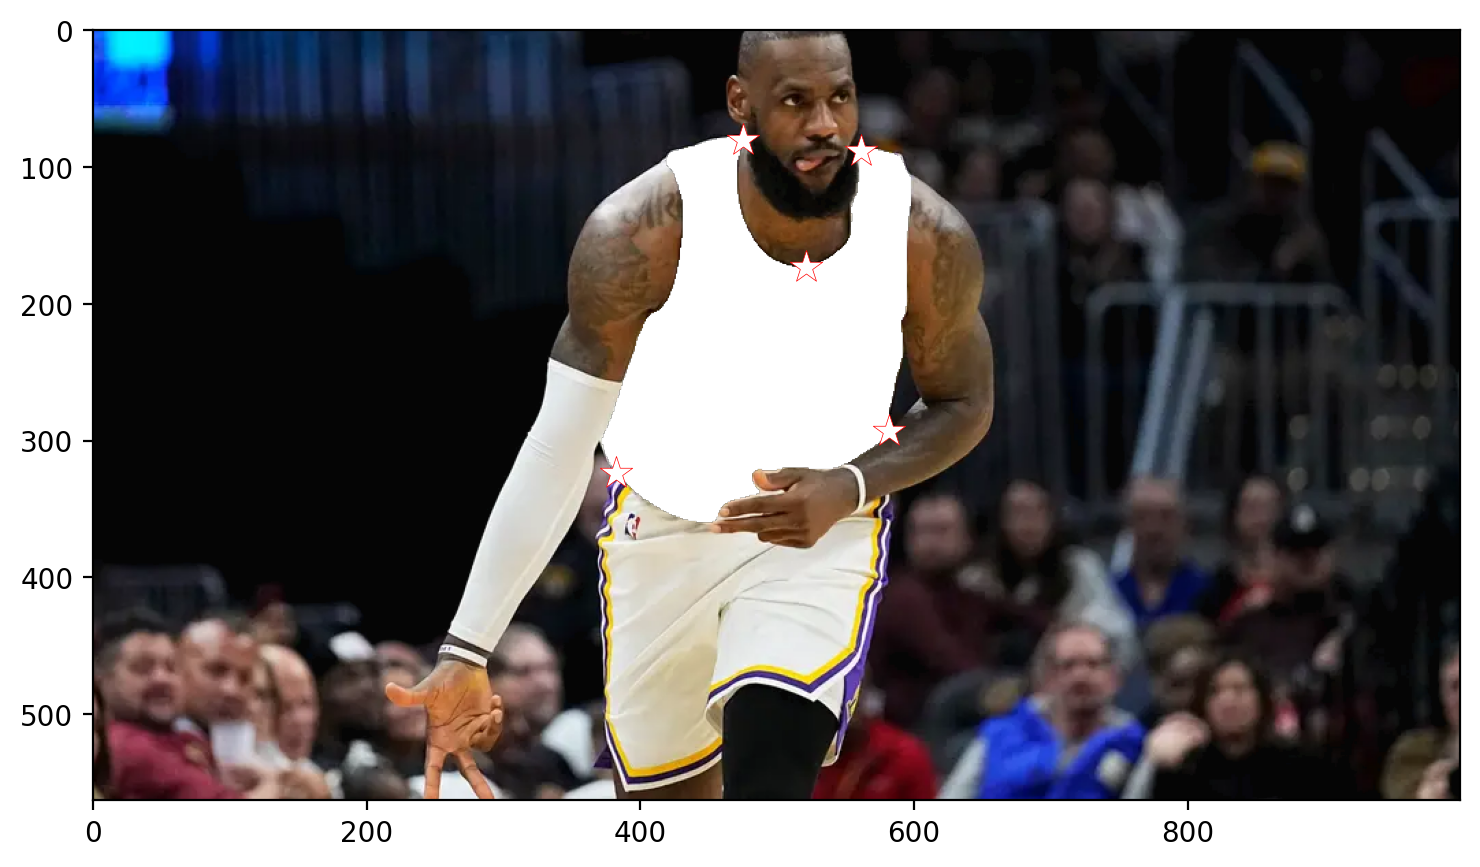

In [ ]:
plt.figure(figsize = [10,5]);
plt.imshow(image_rgb)
show_mask(tweaked, plt.gca())

plt.scatter(keypoints[:, 0], keypoints[:, 1], color='white', marker='*', s=150, edgecolor='red', linewidth=0.25)

path: /content/jersey_views/front_view.png
white space sum: 1044735
spillout sum: 918000
path: /content/jersey_views/right_view.png
white space sum: 1431825
spillout sum: 2165970
path: /content/jersey_views/left_view.png
white space sum: 1471095
spillout sum: 2272050
path: /content/jersey_views/leaned_view.png
white space sum: 568905
spillout sum: 1043460


True

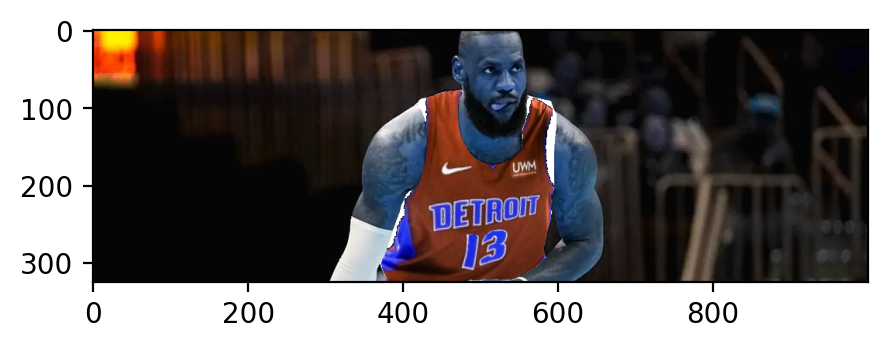

In [ ]:
jersey_list = {
    #white pistons
    "/content/jersey_views/front_view.png":
    np.float32([
      [543, 205],
      [665, 196],
      [609, 283],
      [748, 539],
      [491, 539],
    ]),
    "/content/jersey_views/right_view.png":
    #blue angled pistons
    np.float32([
      [320,172],
      [410,160],
      [346, 194],
      [453, 417],
      [272,421],
    ]),
    "/content/jersey_views/left_view.png":
    #blue angled pistons
    np.float32([
      [355, 152],
      [411, 158],
      [399, 183],
      [441, 364],
      [319,349],
    ]),
    "/content/jersey_views/leaned_view.png":
    #blue angled pistons
    np.float32([
      [287, 28],
      [358, 23],
      [324, 81],
      [392, 172],
      [252, 176],
   ])
}

dst_points = keypoints

white_space = np.float32([999999999])
spillout = np.float32([999999999])
imFilename = None
transformed_img = None

tweaked_inv = np.where(tweaked == 1, 0, 1)

for path in jersey_list:
  src_points = jersey_list[path]
  im2 = cv2.imread(path, cv2.IMREAD_COLOR)
  im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

  #I think the _ might be a mask or something but I havent test it yet
  matrix, _ = cv2.findHomography(src_points, dst_points, 0)
  temp_transformed_img = cv2.warpPerspective(im2, matrix, (tweaked.shape[1], tweaked.shape[0]))

  #havent tested this yet, fix it so its cleaner in the future
  lower = np.array([0,0,0], np.uint8)
  upper = np.array([2,2,2], np.uint8)
  mask = cv2.inRange(temp_transformed_img, lower, upper)
  # tempgray = cv2.cvtColor(temp_transformed_img,cv2.COLOR_BGR2GRAY)
  # ret, mask = cv2.threshold(tempgray, 2, 255, cv2.THRESH_BINARY)
  mask_inv = np.where(mask == 0, 255, 0)
  temp_transformed_img[mask != 0] = [255,255,255]

  #finds the white part after the jersey gets put onto it
  #tweaked is 1s
  #mask is 0s
  temp_white_space = mask*tweaked

  #tweaked_inv is 0s
  #mask_inv is 1s
  temp_spillout = (mask_inv*tweaked_inv)

  print(f"path: {path}")
  print(f"white space sum: {temp_white_space.sum()}")
  print(f"spillout sum: {temp_spillout.sum()}")

  if (temp_white_space.sum()+temp_spillout.sum()) < (white_space.sum()+spillout.sum()):
    white_space = temp_white_space
    spillout = temp_spillout
    imFilename = path
    transformed_img = temp_transformed_img

#cuts out the mask from the og image

#source image over cutout
img1 = transformed_img
img2 = image_rgb * tweaked_inv[:,:, np.newaxis]
img2 = img2.astype(np.uint8)

rows,cols,channels = img2.shape
roi = img1[0:rows, 0:cols]

img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 0, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

dst = cv2.add(img1_bg,img2_fg)
img1[0:rows, 0:cols ] = dst

img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img1 = img1[:keypoints[4,1], :]

plt.figure(figsize=(5, 5))
#shows the pistons jersey over the mask over the image and saves it
plt.axis('on')
plt.imshow(img1)
cv2.imwrite("/content/lama/data_for_prediction/empty2.png", img1)

#shows the white space and saves it
# plt.imshow(white_space)
expanded_white_space = expand_mask_edges(white_space, 3, 1)
expanded_white_space = expanded_white_space[:keypoints[4,1], :]
cv2.imwrite("/content/lama/data_for_prediction/empty2_mask.png", expanded_white_space)


Run inpainting
/content/lama/bin/predict.py:38: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../configs/prediction', config_name='default.yaml')
/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
100% 1/1 [00:08<00:00,  8.37s/it]


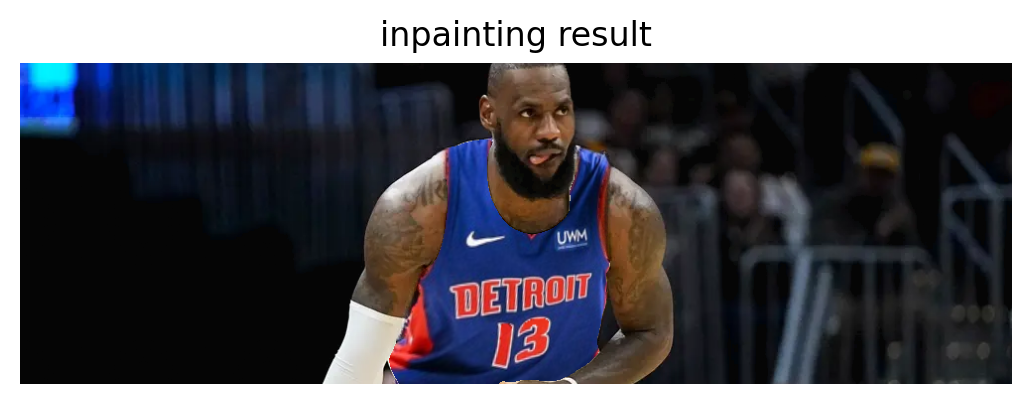

In [ ]:
fname = "empty2.png"

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[0]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()